In [4]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from astropy.table import Table, vstack
import glob


In [50]:
import matplotlib.style as style
style.use('seaborn-colorblind')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize']

[12.0, 8.0]

# How to perform the search for muons in your data

Two ways:
1. Run the `lstchain_data_r0_to_dl1` analysis on real data => The muon analysis is performed simultaneously to the r0_to_dl1 step
1. Run the `lstchain_dl1_muon_analysis` over DL1 files that contain images.

In [ ]:
! lstchain_dl1_muon_analysis --help

### MC

In [ ]:
! lstchain_dl1_muon_analysis \
  --input-file ../data/muons/mc/Scale1.0/dl1_muon_0deg_0deg_run1___cta-prod5-lapalma_desert-2158m--dark.h5 \
  -o ../data/muons/mc/Scale1.0/dl1_muon_test_mc.fits --max-muons 10


In [ ]:
Table.read('../data/muons/mc/Scale1.0/dl1_muon_test_mc.fits', format='fits')

### Real Data

In [33]:
# You need cta-lstchain master to run this because of
# https://github.com/cta-observatory/cta-lstchain/pull/870
#! lstchain_dl1_muon_analysis \
#  --input-file ../data/DL1ab/dl1_LST-1.Run02977.0122.h5 \
#  -o ../data/muons/real/dl1_muon_test_real.fits 

In [ ]:
#t = Table.read('../data/muons/real/dl1_muon_test_real.fits', format='fits')
#t[t['good_ring'] == True ]

In [ ]:
Table.read('../data/muons/real/20201120/v0.8.3/muons_LST-1.Run02977.0122.fits', format='fits')

# MC - Data comparison

In [38]:
def format_axes(ax,option):
    
    if(option=='width'):
        ax.set_xlabel('Muon radius [deg]')
        ax.set_ylabel('Muon ring width [deg]')
        ax.grid(linestyle="dashed")
        #ax.set_ylim(0.042,0.07)
        ax.legend()
    if(option=='size'):
        ax2.grid(linestyle="dashed")
        ax2.legend(ncol=2)
        ax2.set_xlabel('Muon radius [deg]')
        ax2.set_ylabel('Muon Size [pe]')
        ax2.set_ylim(1000,3500)

In [39]:
# Optical efficiencies to be called
OPT_EFF=[0.7, 0.8, 0.9, 1.0]

# size (intensity) outside the ring, to get rid of hadronic showers
size_outside = 500 # phe

## Analyze real muon data from 20201120

In [47]:
from astropy.table import Table, vstack
import glob

listdir = glob.glob('../data/muons/real/20201120/v0.8.3/muons_LST-1.Run02965*')
#listdir = glob.glob('../data/20201120/v0.8.3/muons_LST-1.Run029*')
# Muons analyzed using GlobalPeakWindowSum

dat = Table.read('{}'.format(listdir[0]), format='fits')
for i in range(1,len(listdir)):
    dat2 = Table.read('{}'.format(listdir[i]), format='fits')
    if(len(dat2) == 0):
        continue
    dat = vstack([dat, dat2])

df = dat.to_pandas()
df_good_data = df[df['good_ring']]

Now we load the MC and plot everything together

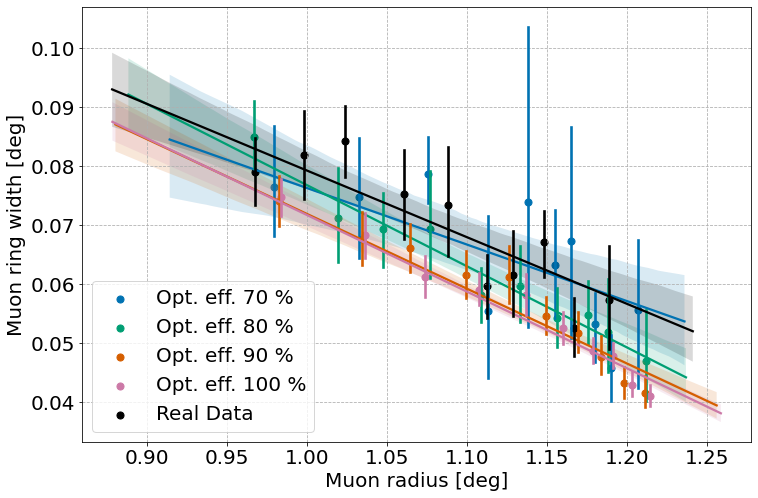

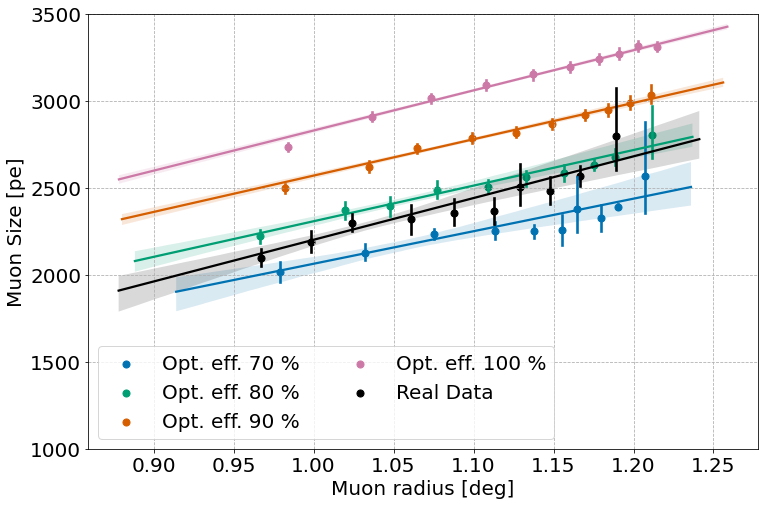

In [53]:
fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()

for j, opt_eff in enumerate(OPT_EFF):
    #listdir=glob.glob(f'../../INFN/Teaching/2021_02_School/intro-iact-analysis/notebooks/data/muons/mc/Scale{opt_eff}/muon_run*')
    listdir=glob.glob(f'../data/muons/mc/Scale{opt_eff}/dl1*fits')
    dat = Table.read('{}'.format(listdir[0]), format='fits')
    for i in range(1,len(listdir)):
        dat2 = Table.read('{}'.format(listdir[i]), format='fits')
        dat = vstack([dat, dat2])
    df = dat.to_pandas()
    df_good = df[df['good_ring']]
    
    
    sns.regplot(x = df_good['ring_radius'][(df_good['ring_completeness'] > 0.9) 
                                           & (df_good['size_outside'] < size_outside)
                                           & (df_good['ring_width'] < 0.3)], 
            y = df_good['ring_width'][(df_good['ring_completeness'] > 0.9) 
                                     & (df_good['size_outside'] < size_outside)
                                     & (df_good['ring_width'] < 0.3)], x_bins=10, 
                ax=ax, color=f'C{j}', label='Opt. eff. %.0f %%' %(opt_eff*100))
    sns.regplot(x = df_good['ring_radius'][(df_good['ring_completeness'] > 0.9) 
                                           & (df_good['size_outside'] < size_outside)
                                           & (df_good['ring_width'] < 0.3)], 
            y = df_good['ring_size'][(df_good['ring_completeness'] > 0.9) 
                                     & (df_good['size_outside'] < size_outside)
                                     & (df_good['ring_width'] < 0.3)], x_bins=10, 
                ax=ax2, color=f'C{j}', label='Opt. eff. %.0f %%' %(opt_eff*100))


sns.regplot(x = df_good_data['ring_radius'][(df_good_data['ring_completeness'] > 0.9) & (df_good_data['size_outside'] < size_outside)], 
            y = df_good_data['ring_width'][(df_good_data['ring_completeness'] > 0.9) & (df_good_data['size_outside'] < size_outside)], 
            x_bins=10, ax=ax, color = 'k', label = 'Real Data')
sns.regplot(x = df_good_data['ring_radius'][(df_good_data['ring_completeness'] > 0.9) & (df_good_data['size_outside'] < size_outside)], 
            y = df_good_data['ring_size'][(df_good_data['ring_completeness'] > 0.9) & (df_good_data['size_outside'] < size_outside)], 
            x_bins=10, ax=ax2, color = 'k', label = 'Real Data')

format_axes(ax,'width')        
format_axes(ax2,'size') 

## Exercises

1. Analyze by yourself MC file
1. Compare the optical efficiency of the different runs in the real data folder and plot them together
1. Extra: Run the `lstchain_data_r0_to_dl1` script over a given subrun of real data using the GlobalPeakIntegrator, analyze the muons contained inside with the `lstchain_dl1_muon_analysis` script and compare the results with those processed by LSTOSA downloaded from the IT cluster